# Sommelier Numerique

Using tasting notes scraped from Wine Enthusiast by [Kaggle](https://www.kaggle.com/zynicide/wine-reviews) user [zachthoutt](https://www.kaggle.com/zynicide) to make new recommendations for wines based on similar tasting notes.

This will be a content-based recommender —- we will use wine reviews to find similar wines based on how their tasting notes describe them, then make a recommendation by looking at both the Wine Enthusiast score (higher score is better) and price (more expensive wines will be penalized).

As a note, there are real memory considerations here, as we consider very large matrices. This gets handled using sparse matrix structures.

*****
## Imports & Data Reading

We will need pandas to read in the data, as well as scikit-surprise to build a simple recommender.

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

import numba

import numpy as np
from scipy.sparse import save_npz, load_npz, lil_matrix, hstack

import pickle

import re

# needed for our loss plots
from IPython.display import clear_output

# using inline, have to set the figure bigger
%matplotlib inline

import numba

from matplotlib import pyplot as plt

# set figure parameters so they look pretty
import matplotlib.pylab as pylab

# Use the Gill Sans font
import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {'legend.fontsize': 14,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20={
    'deep_blue' : (31, 119, 180), 'light_blue' : (174, 199, 232),
    'deep_orange' :  (255, 127, 14), 'light_orange' : (255, 187, 120), 
    'deep_green' :(44, 160, 44), 'light_green' : (152, 223, 138),
    'deep_red' : (214, 39, 40), 'light_red' : (255, 152, 150), 
    'deep_violet' : (148, 103, 189), 'light_violet' : (197, 176, 213), 
    'deep_brown' : (140, 86, 75), 'light_brown': (196, 156, 148), 
    'deep_pink' : (227, 119, 194), 'light_pink' : (247, 182, 210), 
    'deep_gray' : (127, 127, 127), 'light_gray' : (199, 199, 199), 
    'deep_olive' : (188, 189, 34), 'light_olive' : (219, 219, 141), 
    'deep_cyan' : (23, 190, 207), 'light_cyan' : (158, 218, 229)
}

for key in tableau20.keys():    
    r, g, b = tableau20[key]    
    tableau20[key] = (r / 255., g / 255., b / 255.)

*****
## Exploratory data analysis

Take a look at what we've got

In [2]:
# read in the initial data

df = pd.read_csv('../data/winemag-data_first150k.csv')[:50000]

# rescale the points to [0,1]
df['points'] = df['points']/100.
df.head()
print(df.iloc[1])

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,0.96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,0.96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,0.96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,0.96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,0.95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Unnamed: 0                                                     1
country                                                    Spain
description    Ripe aromas of fig, blackberry and cassis are ...
designation                 Carodorum Selección Especial Reserva
points                                                      0.96
price                                                        110
province                                          Northern Spain
region_1                                                    Toro
region_2                                                     NaN
variety                                            Tinta de Toro
winery                                   Bodega Carmen Rodríguez
Name: 1, dtype: object


In [3]:
words = pd.Series([x for x in df['description'].values])
corpus = words.values
print(corpus)

['This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'
 'Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.'
 'Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.'
 ...
 'The wine has firm tannins, w

### Read in Bag of Words

We need to map the vocabulary to a bag of words. This leads to an enormous vocabulary, so eventually we will cut off words that do not appear in more than some threshold number of reviews, to eliminate words that aren't common descriptors of wine. We'll also remove commonly appearing words that don't say anything useful about the wine, from data exploration, and contract some common signifiers that mean the same thing, like "acid" and "acidity".

In [4]:
# minimum fraction of documents in the corpus a vocabulary word appears in, to eliminate
# uncommon descriptors
min_appearance = .0001
max_appearance = .90
max_count = 50

# keep hyphenated words as a single word
pattern = "(?u)\\b[\\w-]+\\b"

# the data cleaning is pretty intensive for large datasets, so we try to do this only once
new_data=False

In [5]:
# want to remove numbers, underscores, adverbs, and possessives from the vocabulary

# some common wine review words to get rid of because they aren't helpful
# derived from data exploration
exclude_words = ['wine', 'flavor', 'finish', 'offer', 'like', 'texture', 
              'note', 'hint', 'good', 'bad', 'great', 'nice', 'year', 
              'kind', 'away', 'time', 'perfect', 'color', 'feel', 'just', 
              'palate', 'best', 'grape', 'tremendous', 'enjoy', 'age', 
              'elegant', 'hail', 'background', 'blend', 'deep', 'pure', 'complex',
             'come']

#evil_words = evil_words + df.variety.str.lower().unique().tolist()

# words that come up as roots of other words, so acid = acidity, etc.
flatten_words = ['acid', 'sweet', 'fruit', 'tannin']

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\b(\w+ly)\b', '', text) # remove adverbs
    text = re.sub(r'\b\w{0,3}\b', '', text) # remove words under 3 characters
    text = text.replace('_', '-')
    
    # get rid of common meaningless words
    for word in exclude_words:
        text = re.sub(r'\w*{}\w*'.format(word), '', text)
        text = re.sub(r'\b({})\b'.format(word), '', text)
        
    # convert synonyms to the root
    for word in flatten_words:
        text = re.sub(r'\w*{}\w*'.format(word), word, text)
        
    return text

In [6]:
if new_data:
    vectorizer = CountVectorizer(stop_words='english', 
                             preprocessor=preprocess_text, 
                             token_pattern=pattern,
                             strip_accents='ascii',
                             min_df=min_appearance,
                             max_df=max_appearance,
                             vocabulary=None,
                             ngram_range=(1,3))
    
    X = vectorizer.fit_transform(corpus)
    
    pickle.dump((X, vectorizer), open('../data/model.p', 'wb'))
                
else:
                
    X, vectorizer = pickle.load(open('../data/model.p', 'rb'))
    
vocabulary = vectorizer.get_feature_names()
n_wines = X.shape[0]
print(X.shape)

(50000, 40146)


In [7]:
Y = np.array(X.todense(), dtype=np.float64)
lens = np.sum(Y, axis=1)
print(lens)

[27. 37. 25. ... 24. 35. 22.]


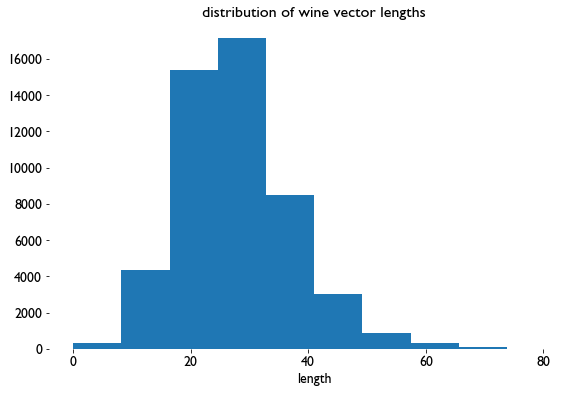

In [15]:
fig, ax = plt.subplots()
ax.hist(lens)
ax.set_xlabel('length')
ax.set_title('distribution of wine vector lengths')
fig.savefig('../figs/gram_dist.png')

pass;

In [9]:
# Summarize the data
print('size of vocabulary = {}'.format(np.shape(X)[1]))

size of vocabulary = 40146


Look at how a few wines get described with our bag-o-words, to see if we get something that makes sense

In [10]:
print(vectorizer.inverse_transform(X[10]))
print(vectorizer.inverse_transform(X[537]))

[array(['juicy', 'fruit', 'ripe', 'delicious', 'white', 'pear', 'aromatic',
       'structure', 'citrus', 'elegance', 'gorgeous', 'ranks', 'whites',
       'opens', 'sublime', 'yellow', 'spring', 'flower', 'herb',
       'orchard', 'scents', 'creamy', 'combines', 'peach', 'almond',
       'savory', 'mineral', 'grace', 'lingering', 'elegance structure',
       'yellow spring', 'spring flower', 'aromatic herb', 'orchard fruit',
       'fruit scents', 'creamy delicious', 'juicy white', 'white peach',
       'peach ripe', 'ripe pear', 'pear citrus', 'citrus white',
       'white almond', 'savory mineral', 'orchard fruit scents',
       'juicy white peach', 'white peach ripe', 'ripe pear citrus',
       'citrus white almond'], dtype='<U34')]
[array(['juicy', 'aromas', 'cassis', 'chocolate', 'baking', 'toasty',
       'drink', 'long', 'long drink', 'berry', 'integrated', 'peppery',
       'spice', 'forward', 'baking spice', 'pepper', 'cabernet', 'franc',
       'petit', 'verdot', 'cabernet f

### Adding the Variety

We will add a one-hot encoding of the variety as a feature, so that we give a little extra weight in our similarity metrics towards wines of the same type. Here we'll one-hot encode the variety and then append it to the bag-of-words for each variety as a `scipy` sparse matrix. This will set us up for the candidate generation model.

In [11]:
variety = pd.get_dummies(df.variety)
variety.head()
spar_var = lil_matrix(variety.values)

region = pd.get_dummies(df.region_1)
region.head()
spar_reg = lil_matrix(region.values)

words_variety = lil_matrix(hstack([X, spar_var, spar_reg]), dtype=np.float64)

,Agiorgitiko,Aglianico,Aidani,Airen,Albana,Albariño,Albarossa,Albarín,Aleatico,Alfrocheiro,...,Xinomavro,Yapincak,Zelen,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Žilavka
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Abruzzo,Adelaida District,Adelaide,Adelaide Hills,Aglianico del Beneventano,Aglianico del Taburno,Aglianico del Vulture,Agrelo,Albana di Romagna,Alcamo,...,Yadkin Valley,Yakima Valley,Yamhill County,Yamhill-Carlton District,Yarra Valley,Yecla,Yolo County,York Mountain,Yorkville Highlands,Yountville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*****
## Candidate Generation Model

We will generate candidate wines by looking for wines from the corpus of wine reviews most similar in profile to an input wine. We will use bag-of-words to generate the feature vectors of wine reviews from the EDA above to define the vocabulary.

In this case, we are answering the question "Given a wine I like, what are some wines that I might want to consider trying?". This is different from "Find me wines similar to one with these traits", and the model will reflect this. Above we have a matrix $W$ of all the words plus variety of each wine, and to make recommendations we will compute the dot product of each wine with the other to get a $N_{\textrm{wines}} \times N_{\textrm{wines}}$ recommendation matrix, $R = W W^t$.

To make a recommendation for the wine that corresponds with index $i$, we look at the highest values of `R[i]` as candidates. We will then score them with a scoring model to exclude wines in different price ranges, and punish lower ratings.

In [12]:
R_matrix = words_variety.dot(words_variety.transpose())
R_matrix.setdiag(0)

Now to generate a few candidates to see if the metric we're using, with the three individual dot products, is yielding things that make sense.

In [13]:
sample_idx = 157
df.loc[sample_idx]
n_rec = 10
sample_vec = R_matrix[sample_idx].todense()
recs = np.argsort(sample_vec)[0,:n_rec:-1].tolist()[0]

Unnamed: 0                                                   157
country                                                       US
description    In this fruit-forward vintage, it's not surpri...
designation                                                  NaN
points                                                      0.89
price                                                         24
province                                                  Oregon
region_1                                            Rogue Valley
region_2                                         Southern Oregon
variety                                               Sangiovese
winery                                              Ledger David
Name: 157, dtype: object

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
35559,35559,US,"Fresh raspberries, red cherries and even black...",Pisoni Vineyard,0.93,60.0,California,Santa Lucia Highlands,Central Coast,Pinot Noir,Siduri
48897,48897,US,"A super Tuscan blend, half Sangiovese, the oth...",Twelve Red,0.90,36.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Lowden Hills
43743,43743,US,"A bright, focused fruitiness is the strength o...",Winemaker's Blend,0.91,20.0,California,Sonoma County-San Joaquin County,California Other,Zinfandel,Ghost Pines
33650,33650,US,"As in the past, Leonetti's 2010 Sangiovese was...",NaN,0.93,65.0,Washington,Walla Walla Valley (WA),Columbia Valley,Sangiovese,Leonetti Cellar
22615,22615,US,"Dark, dusty, strongly scented with barrel toas...",NaN,0.91,45.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Saggi
23258,23258,US,"A pleasantly rich, vibrant Pinot Noir, made in...",NaN,0.88,24.0,California,Carneros,Napa-Sonoma,Pinot Noir,Artesa
12735,12735,US,"Rich in silky bright blackberry fruit, this bl...",Diamond Mine Cuvée,0.91,18.0,California,Lake County,Mendocino/Lake Counties,Red Blend,Six Sigma Ranch
34617,34617,US,"A strong, punchy Pinot Noir, ungainly now for ...",Stiling Vineyard,0.92,50.0,California,Russian River Valley,Sonoma,Pinot Noir,Gary Farrell
24937,24937,US,This extraordinarily rich Syrah swamps the mou...,Garys' Vineyard,0.89,33.0,California,Santa Lucia Highlands,Central Coast,Syrah,Novy
821,821,US,This is a sophisticated blend of tart yellow f...,NaN,0.90,18.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Elizabeth Chambers


In [17]:
print(df.loc[sample_idx].description)

In this fruit-forward vintage, it's not surprising to find that what shines here are the bright, spicy and tart flavors of strawberries, raspberries and cherries. The Sangiovese was co-fermented with 7% Syrah, and aged in 30% new American oak. As the wine breathes open the flavors of oak and char come up, and the tannins show some extra grip.


In [19]:
for idx in range(0, n_rec):
    print(df.loc[recs[idx]])
    print(df.loc[recs[idx]].description)

Unnamed: 0                                                 35559
country                                                       US
description    Fresh raspberries, red cherries and even black...
designation                                      Pisoni Vineyard
points                                                      0.93
price                                                         60
province                                              California
region_1                                   Santa Lucia Highlands
region_2                                           Central Coast
variety                                               Pinot Noir
winery                                                    Siduri
Name: 35559, dtype: object
Fresh raspberries, red cherries and even blackberries arise on the juicy nose of this wine from Adam Lee, but it's lifted by wild mint, hummingbird sage and damp coyote scrub. The palate is very herbally spiced, with thyme, marjoram, black cardamom and charr

*****
## Scoring Model

The candidates we choose will be similar to the wine we're asking to compare. To sort them into recommendations, we will sort by the score, and punish for being more or less expensive.